In [3]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 265 kB/s 
     |████████████████████████████████| 141 kB 8.5 MB/s 
     |████████████████████████████████| 203 kB 46.5 MB/s 
     |████████████████████████████████| 48 kB 4.4 MB/s 
     |████████████████████████████████| 272 kB 51.9 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 802 kB 50.4 MB/s 
     |████████████████████████████████| 132 kB 40.2 MB/s 
     |████████████████████████████████| 1.0 MB 41.8 MB/s 
     |████████████████████████████████| 54.5 MB 106 kB/s 
     |████████████████████████████████| 1.6 MB 39.8 MB/s 
     |████████████████████████████████| 281 kB 51.4 MB/s 
     |████████████████████████████████| 585 kB 38.6 MB/s 
     |████████████████████████████████| 

Multimodal Data Tables: Tabular, Text, and Image
Tip: Prior to reading this tutorial, it is recommended to have a basic understanding of the TabularPredictor API covered in Predicting Columns in a Table - Quick Start.

In this tutorial, we will train a multi-modal ensemble using data that contains image, text, and tabular features.

Note: A GPU is required for this tutorial in order to train the image and text models. Additionally, GPU installations are required for MXNet and Torch with appropriate CUDA versions.

The PetFinder Dataset
We will be using the PetFinder dataset. The PetFinder dataset provides information about shelter animals that appear on their adoption profile with the goal to predict the adoption rate of the animal. The end goal is for rescue shelters to use the predicted adoption rate to identify animals whose profiles could be improved so that they can find a home.

Each animal’s adoption profile contains a variety of information, such as pictures of the animal, a text description of the animal, and various tabular features such as age, breed, name, color, and more.

To get started, we first need to download the dataset. Datasets that contain images require more than a CSV file, so the dataset is packaged in a zip file in S3. We will first download it and unzip the contents:

In [4]:
download_dir = './ag_petfinder_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_kaggle.zip'

In [5]:
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 2.00G/2.00G [02:36<00:00, 12.8MiB/s]


Examine contents of dataset

In [6]:
import os
os.listdir(download_dir)

['file.zip', 'petfinder_processed']

‘file.zip’ is the original zip file we downloaded, and ‘petfinder_processed’ is a directory containing the dataset files.

In [7]:
dataset_path = download_dir + '/petfinder_processed'
os.listdir(dataset_path)

['train_images', 'dev.csv', 'train.csv', 'test_images', 'test.csv']

Here we can see the train, test, and dev CSV files, as well as two directories: ‘test_images’ and ‘train_images’ which contain the image JPG files.

Note: We will be using the dev data as testing data as dev contains the ground truth labels for showing scores via predictor.leaderboard.

Let’s take a peek at the first 10 files inside of the ‘train_images’ directory:

In [8]:
os.listdir(dataset_path + '/train_images')[:10]

['9d8032dd0-1.jpg',
 '28e86de6d-4.jpg',
 'f20fa5c38-9.jpg',
 '08b9a3a2f-1.jpg',
 'dde4e26d1-4.jpg',
 'e53933782-2.jpg',
 '547a18b80-2.jpg',
 '348665874-4.jpg',
 'dcefbb974-2.jpg',
 'a4221001f-2.jpg']

As expected, these are the images we will be training with alongside the other features.

Next, we will load the train and dev CSV files:

In [9]:
import pandas as pd

train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/dev.csv', index_col=0)

In [26]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
8695,2,Putih,36,265,0,2,1,7,0,3,...,2,50,41326,b990f8dcaa97abbc385bb78ff772ea84,0,"-Putih Sangat Manja , -Gemuk, -Bulu lebat, dan...",3b140cca4,4.0,2,/content/ag_petfinder_tutorial/petfinder_proce...
13100,1,URGENT !!! Yo Yo,48,218,179,2,5,0,0,2,...,1,0,41326,471d59d2b221fe60eca90d131c415ff6,0,Yo is such an obedient n a beautiful girl.. sh...,8ef541435,3.0,3,/content/ag_petfinder_tutorial/petfinder_proce...
14114,1,Zone A3 P1,2,307,0,1,2,7,0,1,...,1,0,41326,37237ca3633d20c004ec76c0c2ddb4b7,0,Contact Furry Friends Farm for more further in...,36a5b3b3e,2.0,4,/content/ag_petfinder_tutorial/petfinder_proce...


3 rows × 25 columns

Looking at the first 3 examples, we can tell that there is a variety of tabular features, a text description (‘Description’), and an image path (‘Images’).

For the PetFinder dataset, we will try to predict the speed of adoption for the animal (‘AdoptionSpeed’), grouped into 5 categories. This means that we are dealing with a multi-class classification problem.

In [10]:
label = 'AdoptionSpeed'
image_col = 'Images'

Preparing the image column
Let’s take a look at what a value in the image column looks like:



In [11]:
train_data[image_col].iloc[0]

'train_images/e4b90955c-1.jpg;train_images/e4b90955c-2.jpg;train_images/e4b90955c-3.jpg;train_images/e4b90955c-4.jpg'

Currently, AutoGluon only supports one image per row. Since the PetFinder dataset contains one or more images per row, we first need to preprocess the image column to only contain the first image of each row.

In [12]:
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0])
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

train_data[image_col].iloc[0]

'train_images/e4b90955c-1.jpg'

AutoGluon loads images based on the file path provided by the image column.

Here we update the path to point to the correct location on disk:



In [13]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_petfinder_tutorial/petfinder_processed/train_images/e4b90955c-1.jpg'

In [14]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
10721,1,Elbi,2,307,307,2,5,0,0,3,...,1,0,41336,e9a86209c54f589ba72c345364cf01aa,0,I'm looking for people to adopt my dog,e4b90955c,4.0,4,/content/ag_petfinder_tutorial/petfinder_proce...
13114,2,Darling,4,266,0,1,1,0,0,2,...,1,0,41401,01f954cdf61526daf3fbeb8a074be742,0,Darling was born at the back lane of Jalan Alo...,a0c1384d1,5.0,3,/content/ag_petfinder_tutorial/petfinder_proce...
13194,1,Wolf,3,307,0,1,1,2,0,2,...,1,0,41332,6e19409f2847326ce3b6d0cec7e42f81,0,I found Wolf about a month ago stuck in a drai...,cf357f057,7.0,4,/content/ag_petfinder_tutorial/petfinder_proce...


Analyzing an example row
Now that we have preprocessed the image column, let’s take a look at an example row of data and display the text description and the picture.



In [15]:
example_row = train_data.iloc[1]

example_row

Type                                                             2
Name                                                       Darling
Age                                                              4
Breed1                                                         266
Breed2                                                           0
Gender                                                           1
Color1                                                           1
Color2                                                           0
Color3                                                           0
MaturitySize                                                     2
FurLength                                                        1
Vaccinated                                                       2
Dewormed                                                         2
Sterilized                                                       2
Health                                                        

In [16]:
example_row['Description']

'Darling was born at the back lane of Jalan Alor and was foster by a feeder. All his siblings had died of accident. His mother and grandmother had just been spayed. Darling make a great condo/apartment cat. He love to play a lot. He would make a great companion for someone looking for a cat to love.'

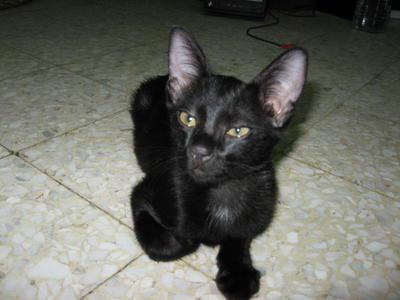

In [17]:
example_image = example_row['Images']

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

In [27]:
example_row_77 = train_data.iloc[77]

example_row_77

Type                                                             2
Name                                                          Neng
Age                                                              4
Breed1                                                         264
Breed2                                                           0
Gender                                                           1
Color1                                                           4
Color2                                                           0
Color3                                                           0
MaturitySize                                                     3
FurLength                                                        3
Vaccinated                                                       2
Dewormed                                                         1
Sterilized                                                       2
Health                                                        

In [29]:
example_row_77['Description']

'Friendly with humans and other cats. Very playful, already litter box trained. Interested call/sms. Area Damansara. Self collect.'

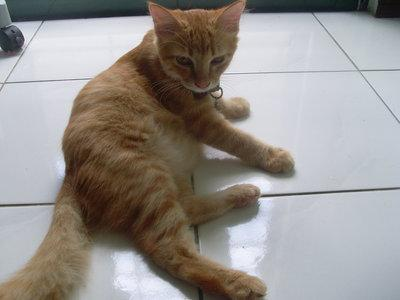

In [30]:
example_image_77 = example_row_77['Images']

from IPython.display import Image, display
pil_img = Image(filename=example_image_77)
display(pil_img)

In [18]:
train_data = train_data.sample(500, random_state=0)

The PetFinder dataset is fairly large. For the purposes of the tutorial, we will sample 500 rows for training.

Training on large multi-modal datasets can be very computationally intensive, especially if using the best_quality preset in AutoGluon. When prototyping, it is recommended to sample your data to get an idea of which models are worth training, then gradually train with larger amounts of data and longer time limits as you would with any other machine learning algorithm.



Constructing the FeatureMetadata
Next, let’s see what AutoGluon infers the feature types to be by constructing a FeatureMetadata object from the training data:



In [19]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(train_data)

print(feature_metadata)

('float', [])        :  1 | ['PhotoAmt']
('int', [])          : 19 | ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', ...]
('object', [])       :  4 | ['Name', 'RescuerID', 'PetID', 'Images']
('object', ['text']) :  1 | ['Description']


Notice that FeatureMetadata automatically identified the column ‘Description’ as text, so we don’t need to manually specify that it is text.

In order to leverage images, we need to tell AutoGluon which column contains the image path. We can do this by specifying a FeatureMetadata object and adding the ‘image_path’ special type to the image column. We later pass this custom FeatureMetadata to TabularPredictor.fit.

Specifying the hyperparameters
Next, we need to specify the models we want to train with. This is done via the hyperparameters argument to TabularPredictor.fit.

AutoGluon has a predefined config that works well for multimodal datasets called ‘multimodal’. We can access it via:

In [23]:
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
hyperparameters = get_hyperparameter_config('multimodal')

hyperparameters

{'AG_IMAGE_NN': {},
 'AG_TEXT_NN': {'presets': 'medium_quality_faster_train'},
 'CAT': {},
 'GBM': [{},
  {'ag_args': {'name_suffix': 'XT'}, 'extra_trees': True},
  'GBMLarge'],
 'NN_TORCH': {},
 'VW': {},
 'XGB': {}}

This hyperparameter config will train a variety of Tabular models as well as finetune an Electra BERT text model, and a ResNet image model.

In [24]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label).fit(
    train_data=train_data,
    hyperparameters=hyperparameters,
    feature_metadata=feature_metadata,
    time_limit=900,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220628_001533/"
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20220628_001533/"
AutoGluon Version:  0.5.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    500
Train Data Columns: 24
Label Column: AdoptionSpeed
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 4, 0, 1]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12252.94 MB
	Train Data (Original)  Memory Usage: 0.46 MB (0.0% of available memory

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 13.7 M
1 | validation_metric | Accuracy            | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
13.7 M    Trainable params
0         Non-trainable params
13.7 M    Total params
27.305    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'val_accuracy' reached 0.24000 (best 0.24000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=0-step=1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 4: 'val_accuracy' reached 0.27000 (best 0.27000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=0-step=4.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 5: 'val_accuracy' reached 0.28000 (best 0.28000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=1-step=5.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 8: 'val_accuracy' reached 0.26000 (best 0.28000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=1-step=8.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 9: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 12: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 13: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 16: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 17: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 20: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 21: 'val_accuracy' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 24: 'val_accuracy' reached 0.27000 (best 0.28000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=5-step=24.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 25: 'val_accuracy' reached 0.28000 (best 0.28000), saving model to '/content/AutogluonModels/ag-20220628_001533/models/TextPredictor/epoch=6-step=25.ckpt' as top 3
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

	0.28	 = Validation score   (accuracy)
	101.66s	 = Training   runtime
	0.92s	 = Validation runtime
Fitting model: ImagePredictor ... Training model for up to 766.48s of the 766.47s of remaining time.
ImagePredictor sets accuracy as default eval_metric for classification problems.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet50
root.misc.seed       42 != 716
root.misc.num_workers 4 != 2
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
root.train.batch_size 32 != 16
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 15
}
Saved config to /content/AutogluonModels/ag-20220628_001533/models/ImagePredictor/a8001b2e/.trial_0/config.yaml
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14

Predicting: 0it [00:00, ?it/s]

In [25]:
leaderboard = predictor.leaderboard(test_data)

Load pretrained checkpoint: AutogluonModels/ag-20220628_001533/models/TextPredictor/text_nn/model.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMLarge    0.323775       0.37        0.023232       0.009166    2.610180                 0.023232                0.009166           2.610180            1       True          6
1  WeightedEnsemble_L2    0.323775       0.37        0.030477       0.009653    2.841596                 0.007244                0.000487           0.231416            2       True          8
2       NeuralNetTorch    0.319773       0.35        0.090394       0.027519    4.601189                 0.090394                0.027519           4.601189            1       True          5
3             CatBoost    0.319106       0.30        0.034373       0.021130   13.533418                 0.034373                0.021130          13.533418            1       True          3
4           LightGBMXT    0.315772      